<a href="https://colab.research.google.com/github/Niroth36/Convolutional_Neural_Networks_CRCslides_dataset/blob/main/CRC_slides_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries we need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

## Mounting drive to use CRC_slides dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/datasets/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

Count the number of all the photos in the dataset

In [15]:
from pathlib import Path
data_dir = Path('/content/CRC_slides')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

7180


## Develop load_dataset function

In [20]:
def load_dataset(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):
  # Create train set
  train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=val_pct+test_pct, color_mode='rgb', subset="training",
                                                         seed=123, image_size=img_size, batch_size=batch_size)
  # Create test set
  val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=val_pct+test_pct, subset="validation", color_mode='rgb',
                                                       seed=123, image_size=img_size, batch_size=batch_size)
  # Split batches of validation test set into test set and the rest in the validation set
  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take(val_batches // 2)
  val_ds = val_ds.skip(val_batches // 2)
  # Create development set from concatenating training set and validation set, without using test set
  devel_ds = tf.data.Dataset.concatenate(train_ds, val_ds)
  # Finding class names from the class_names attribute on these datasets
  class_names = train_ds.class_names

  return devel_ds, train_ds, val_ds, test_ds, class_names

In [21]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.
Using 4308 files for training.
Found 7180 files belonging to 9 classes.
Using 2872 files for validation.


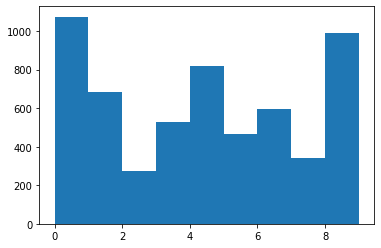

In [22]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()